In [29]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

### Basic Iteration Method (FGSM)
- targeted attack

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>X</mi>
    <mi>adv</mi>
  </msub>
  <msup>
    <mi>N</mi>
    <mo>+</mo>
    <mn>1</mn>
  </msup>
  <mo>=</mo>
  <mi>Clip</mi>
  <mo>{</mo>
  <mi>X</mi>
  <mo>+</mo>
  <mi>&#x3B1;</mi>
  <mo>&#x22C5;</mo>
  <mi>sign</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mo>&#x2207;</mo>
    <mi>X</mi>
  </msub>
  <mi>J</mi>
  <mo stretchy="false">(</mo>
  <mi>&#x3B8;</mi>
  <mo>,</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">)</mo>
  <mo>}</mo>
</math>

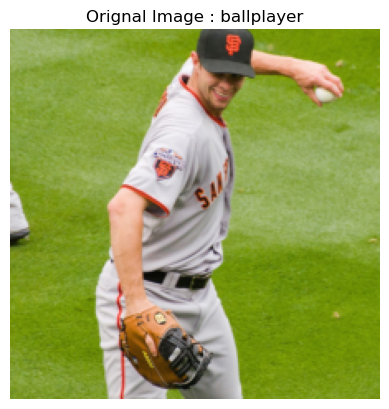

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image= "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)
output = model(image_tensor)
_, predict = torch.max(output,1)

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0 ,1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f'Orignal Image : {labels}')
plt.show()

In [30]:
def bim_fgsm(image, target, epsilon, alpha, num_iter):
    target = torch.tensor([target]).to(device)
    perturbed_image = image.clone().detach().to(device)
    perturbed_image.requires_grad = True
    for _ in tqdm(range(num_iter), desc="Basic Iteration"):
        output = model(perturbed_image)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + alpha * data_grad.sign()
        perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon).detach()
        perturbed_image.requires_grad = True  # Re-enable requires_grad after detach

    return perturbed_image

In [32]:
epsilon = 0.01
alpha = 1
num_iter = 1000
target = 2

adversarial_image = bim_fgsm(image_tensor, target, epsilon, alpha, num_iter)

adversarial_output = model(adversarial_image)

_, adversarial_predict = torch.max(adversarial_output, 1)

adversarial_labels = idx2label[adversarial_predict.item()]

print(adversarial_labels)

Basic Iteration: 100%|██████████| 1000/1000 [00:12<00:00, 78.28it/s]

ballplayer
